In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
#Calibrating the Camera

#filenames of all calibration images
files = glob.glob('./camera_cal/calibration*.jpg')

chessshape = (9,6)
objpoints = [] # Real world coordinates in 3D
imgpoints = [] # 2D points in image plane

cal_images = [] # all images of calibration

# setup object points consant for each calibration image
objp = np.zeros((chessshape[0]*chessshape[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessshape[0],0:chessshape[1]].T.reshape(-1,2)

# iterate through all images
for fname in files:
    # read image
    image = cv2.imread(fname)
    cal_images.append(np.copy(image))
    # convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # find chesscorners
    ret, corners = cv2.findChessboardCorners(gray, chessshape, None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        img = cv2.drawChessboardCorners(image, chessshape, corners, ret)

# Actual calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

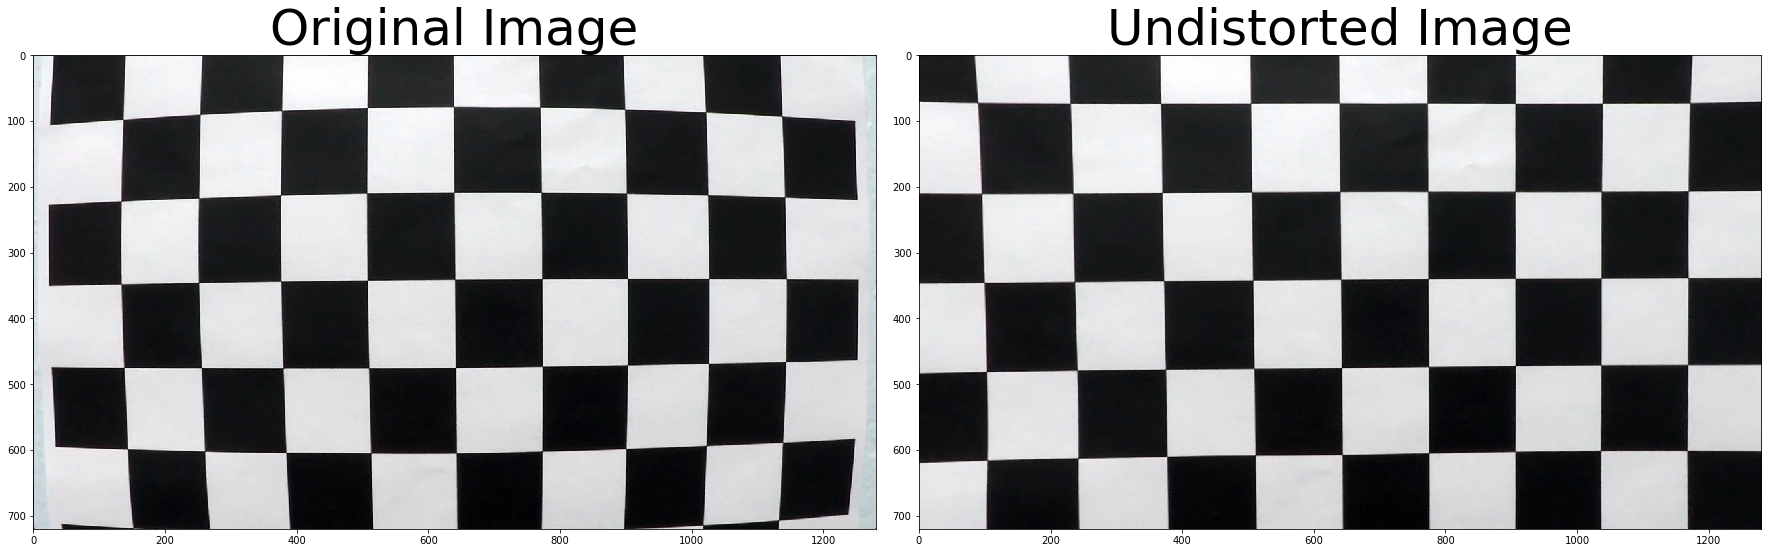

In [3]:
# test calibration on chessboard

# test calibration image
test_cal_image = cv2.imread('./camera_cal/calibration1.jpg')

dst = cv2.undistort(test_cal_image, mtx, dist, None, mtx)

# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


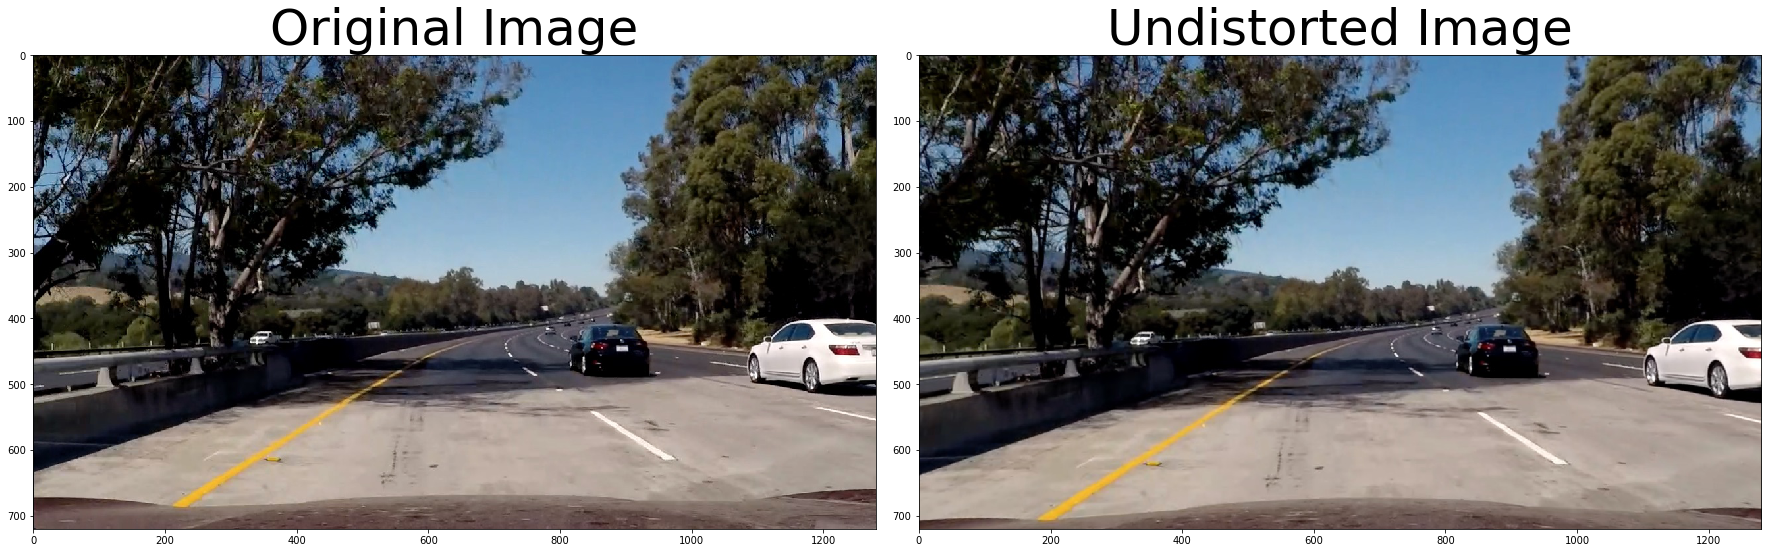

In [4]:
 # test calibration on image of road


# test images
test_files = glob.glob('./test_images/*.jpg')
test_files.sort()
test_images = []
for test_file in test_files:
    test_image = cv2.imread(test_file)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    test_images.append(test_image)

# test image
test_image = cv2.imread('./test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(test_image, mtx, dist, None, mtx)


# Plot calibration result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


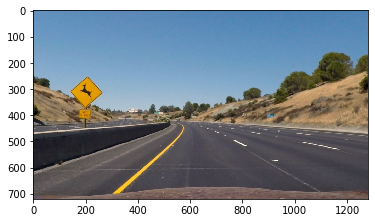

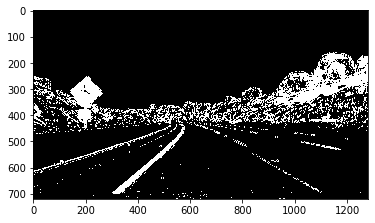

In [5]:
# show image
def show(img):
    plt.figure()
    plt.imshow(img, cmap='gray')

# Converts image to gray image
def cvtGray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Applies thresholds to image
def threshold(img, thresh=(0, 255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

# Scales the image to use full spectrum from 255
def scale(img): 
    return np.uint8(255*img/np.max(img))

# combines to images with 'and' or 'or' operator
def combine(img, operator, img2):
    binary_output = np.zeros_like(img)
    if(operator == 'and'):
        binary_output[(img == 1) & (img2 == 1)] = 1
    elif(operator == 'or'):
        binary_output[(img == 1) | (img2 == 1)] = 1
    return binary_output

def potLanePixel(img):
    gray = cvtGray(img)
    # gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 9)
    # absolute value of the x
    abs_sobelx = np.abs(sobelx)

    scaled_sobelx = scale(abs_sobelx)

    bin_sobelx = threshold(scaled_sobelx, thresh=(20,100))

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sat = threshold(S, thresh=(90,255))
    hue = threshold(H, thresh=(15,100))

    combo_s_h = combine(sat,'and', hue) 
 
    result = combine(combo_s_h,'or', bin_sobelx)
    return result



 # show image
show(test_images[3])
show(potLanePixel(test_images[3]))

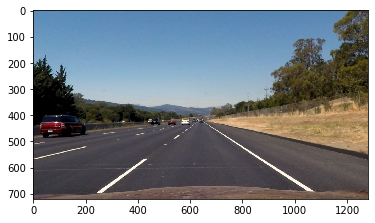

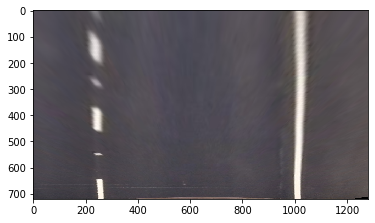

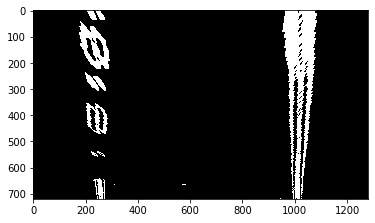

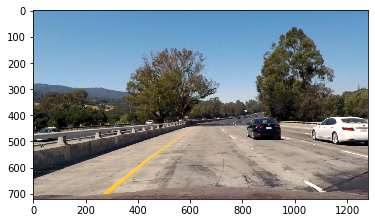

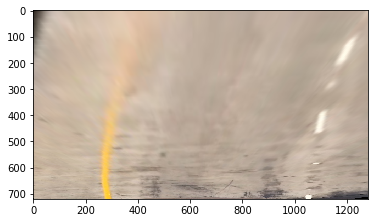

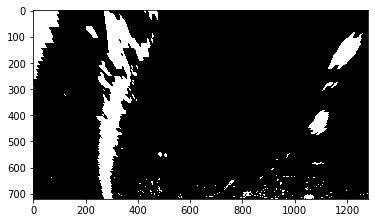

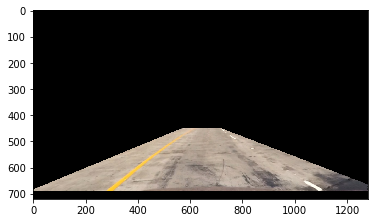

In [6]:
# transform perspective to birdseye

perspective_test = test_images[2]

# approximated from an image with straight lane lines
src = np.float32([[250,690],[1050,690],[597,450],[686,450]])
dst = np.float32([[250,720],[1000,720],[250,0],[1000,0]])

M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)

def warp(img):
    return cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

def unwarp(img):
    return cv2.warpPerspective(img, M_inv, img.shape[1::-1], flags=cv2.INTER_LINEAR)

show(test_images[1])
show(warp(test_images[1]))
show(warp(potLanePixel(test_images[1])))

show(perspective_test)
show(warp(perspective_test))
show(warp(potLanePixel(perspective_test)))
show(unwarp(warp(perspective_test)))

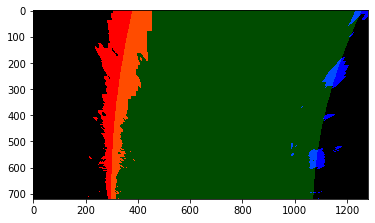

In [22]:
# identify lines out of potential lane line pixels

def base_points(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    midpoint = img.shape[1]//2
    return np.argmax(histogram[:midpoint]), np.argmax(histogram[midpoint:]) + midpoint

image = test_images[5]

warp_bin = warp(potLanePixel(image))

def find_start_lane_pixels(warp_bin):
    leftx_base, rightx_base = base_points(warp_bin)

    n_win = 9

    margin = 100

    minpix = 50

    window_height = np.int(image.shape[0]//n_win)

    nonzero = warp_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(n_win):
        win_y_low = warp_bin.shape[0] - (window+1) * window_height
        win_y_high = warp_bin.shape[0] - window * window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)

        if len(left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))

        if len(right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

# fit polynomial
def fitPolynomial(warp_bin):
    leftx, lefty, rightx, righty = find_start_lane_pixels(warp_bin)

    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(warp_bin.shape, leftx, lefty, rightx, righty)

    return lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit
    
def fit_poly(img_shape, leftx, lefty, rightx, righty):

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(warp_bin, left_fit, right_fit):
    margin = 100

    nonzero = warp_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_center = left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + left_fit[2]
    rightx_center = right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + right_fit[2]
    left_lane_inds = (nonzerox <= leftx_center + margin) & (nonzerox > leftx_center - margin) 
    right_lane_inds = (nonzerox <= rightx_center + margin) & (nonzerox > rightx_center - margin) 
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(warp_bin.shape, leftx, lefty, rightx, righty)

    return lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit

def visualizeLines(warp_bin, lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx):

    out_img = np.dstack((warp_bin, warp_bin, warp_bin))*255
    lines_img = np.zeros_like(out_img)
    window_img = np.zeros_like(out_img)

    lines_img[lefty, leftx] = [255, 0, 0]
    lines_img[righty, rightx] = [0, 0, 255]

    lane_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_pts = np.hstack((lane_window1, lane_window2))
    
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
    result = cv2.addWeighted(lines_img, 1, window_img, 0.3, 0)
    return result

lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit = fitPolynomial(warp_bin)
poly_img = visualizeLines(warp_bin,lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx)

show(poly_img)

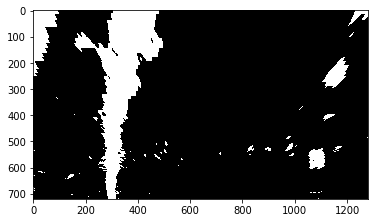

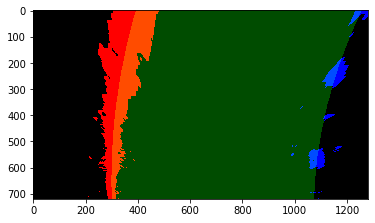

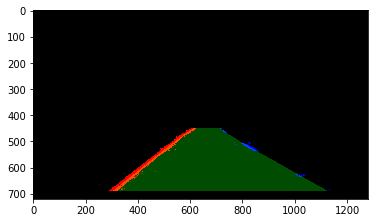

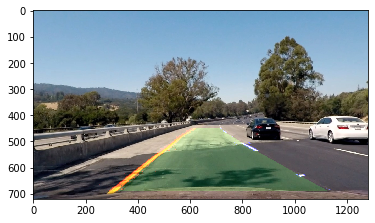

In [8]:


lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx = search_around_poly(warp_bin, left_fit, right_fit)
show(warp_bin)
poly_img = visualizeLines(warp_bin, lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx)

show(poly_img)

unwarped_vis = unwarp(poly_img)
show(unwarped_vis)

result = cv2.addWeighted(image, 1, unwarped_vis, 0.5, 0)
show(result)



In [9]:
def measure_curvature_real(y_eval, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curverad = (1+(2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(1.5) / np.abs(2*left_fit_cr[0])
    right_curverad = (1+(2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(1.5) / np.abs(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def offset_from_center(car_center, leftx, rightx):
    lane_center = (rightx-leftx)//2 + leftx
    return np.abs(lane_center - car_center)

left_curverad, right_curverad = measure_curvature_real(img.shape[0], left_fit, right_fit)

print(left_curverad, 'm', right_curverad, 'm')

3249.485273617938 m 2176.7402264532734 m


In [10]:
# Define a class to receive the characteristics of each line detection
# provided by udacity
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

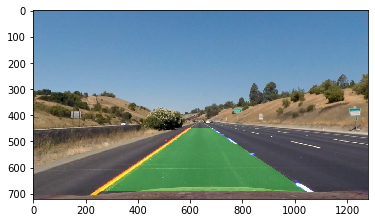

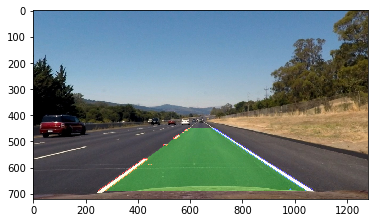

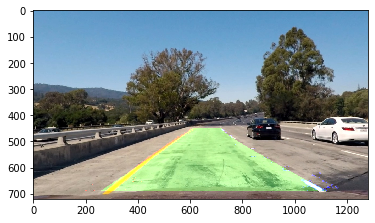

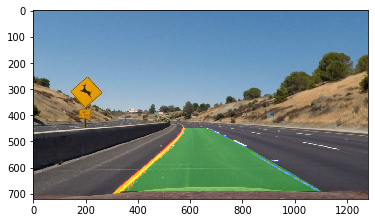

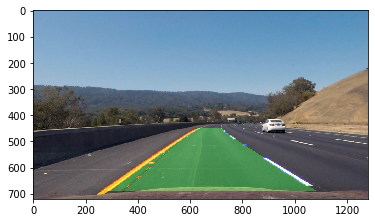

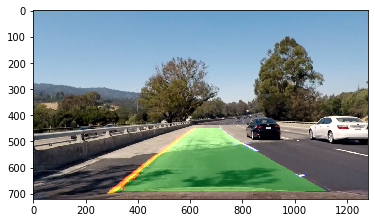

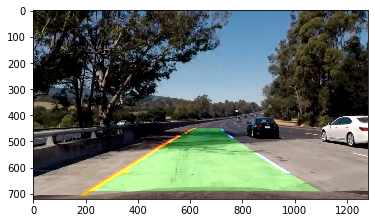

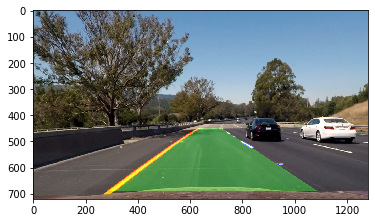

In [23]:
right_line = Line()
left_line = Line()
def pipeline(img, left_line, right_line):
    warp_bin = warp(potLanePixel(img))
    if(left_line.detected and right_line.detected):
        lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit = search_around_poly(warp_bin, left_line.best_fit, right_line.best_fit)
    else:
        lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx, left_fit, right_fit = fitPolynomial(warp_bin)
        left_line.best_fit = left_fit
        right_line.best_fit = right_fit
        left_line.detected = True
        right_line.detected = True
    poly_img = visualizeLines(warp_bin,lefty, leftx, righty, rightx, ploty, left_fitx, right_fitx)
    unwarped_vis = unwarp(poly_img)
    result = cv2.addWeighted(img, 1, unwarped_vis, 1, 0)
    return result, left_line, right_line

for i in test_images:
    img,_,_ = pipeline(i, Line(),Line())
    show(img)

In [24]:
# libs for videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
left_line = Line()
right_line = Line()
def process_image(image):
    global left_line
    global right_line
    result, left_line, right_line = pipeline(image, left_line, right_line)
    return result

In [26]:
project_output = 'project_video_output.mp4'

left_line = Line()
right_line = Line()

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)

AttributeError: 'tuple' object has no attribute 'shape'

In [19]:
project_output = 'challenge_video_output.mp4'

clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)


t:   0%|          | 1/1260 [06:48<142:58:53, 408.84s/it, now=None]

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

t:   1%|          | 3/485 [00:00<00:18, 25.67it/s, now=None]Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



t:   1%|          | 5/485 [00:00<00:21, 22.68it/s, now=None]

t:   1%|▏         | 7/485 [00:00<00:22, 21.05it/s, now=None]

t:   2%|▏         | 9/485 [00:00<00:23, 19.95it/s, now=None]

t:   2%|▏         | 11/485 [00:00<00:24, 19.36it/s, now=None]

t:   3%|▎         | 13/485 [00:00<00:24, 18.95it/s, now=None]

t:   3%|▎         | 15/485 [00:00<00:25, 18.53it/s, now=None]

t:   4%|▎         | 17/485 [00:00<00:25, 18.18it/s, now=None]

t:   4%|▍         | 19/485 [00:01<00:25, 18.12it/s, now=None]

t:   4%|▍         | 21/485 [00:01<00:25, 18.10it/s, now=None]

t:   5%|▍         | 23/485 [00:01<00:25, 18.08it/s, now=None]

t:   5%|▌         | 25/485 [00:01<00:25, 17.81it/s, now=None]

t:   6%|▌         | 

In [20]:
project_output = 'harder_challenge_video_output.mp4'

clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(project_output, audio=False)

%|█████▋    | 677/1199 [00:50<00:39, 13.09it/s, now=None]

t:  57%|█████▋    | 679/1199 [00:50<00:39, 13.21it/s, now=None]

t:  57%|█████▋    | 681/1199 [00:50<00:38, 13.29it/s, now=None]

t:  57%|█████▋    | 683/1199 [00:51<00:38, 13.55it/s, now=None]

t:  57%|█████▋    | 685/1199 [00:51<00:37, 13.86it/s, now=None]

t:  57%|█████▋    | 687/1199 [00:51<00:36, 14.05it/s, now=None]

t:  57%|█████▋    | 689/1199 [00:51<00:36, 13.96it/s, now=None]

t:  58%|█████▊    | 691/1199 [00:51<00:36, 13.87it/s, now=None]

t:  58%|█████▊    | 693/1199 [00:51<00:37, 13.55it/s, now=None]

t:  58%|█████▊    | 695/1199 [00:51<00:37, 13.43it/s, now=None]

t:  58%|█████▊    | 697/1199 [00:52<00:39, 12.87it/s, now=None]

t:  58%|█████▊    | 699/1199 [00:52<00:39, 12.82it/s, now=None]

t:  58%|█████▊    | 701/1199 [00:52<00:38, 12.79it/s, now=None]

t:  59%|█████▊    | 703/1199 [00:52<00:38, 12.93it/s, now=None]

t:  59%|█████▉    | 705/1199 [00:52<00:38, 12.91it/s, now=None]

t:  59%|█████▉    | 707/1199 [0